#  This is Lab 1 executable file
This file contains the program code that is the solution to the tasks from the file [lab_1_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_1/lab_1_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [1]:
# libs initialization
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sp

from datetime import datetime
from prettytable import PrettyTable
from scipy.optimize import curve_fit, minimize

In [2]:
# Dataset initialization
path_to_file = '../Datasets/match_map_stats.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.head(7)

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2
5,2018-01-11 00:51:16,2018-01-11 00:56:55,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,4,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,0.000000,36.396057,NaN,NaN,3,4
6,2018-01-11 01:11:32,2018-01-11 01:16:33,Overwatch League - Stage 1,10223,3,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Ilios,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,0.000000,0.000000,99.0,100.0,0,1


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

In [3]:
# Colums renaming and data preparation

# Recretion of timestamps columns in length of the game column
source_df['round_start_time'] = source_df['round_start_time'].astype(str)
source_df['round_end_time'] = source_df['round_end_time'].astype(str)
glength = []
for i in range(0, len(source_df['round_start_time'])):
    finaltime = datetime.strptime(source_df['round_end_time'][i], '%Y-%m-%d %H:%M:%S')
    starttime = datetime.strptime(source_df['round_start_time'][i], '%Y-%m-%d %H:%M:%S')
    td = finaltime - starttime
    glength.append(td.seconds)
source_df['game_length'] = glength
source_df['game_length'] = source_df['game_length'].astype(int)

# deleting unused columns
# source_df = source_df.drop(['round_start_time', 'round_end_time', 'match_id', 'attacker_control_perecent',	'defender_control_perecent', 'team_one_name', 'team_two_name', 'control_round_name'], axis = 1)
source_df = source_df[['attacker_round_end_score', # this is the value we will predict (target)
                        'map_name', # this is our category sorter
                        'game_length', # all other values are the predictors
                        'defender_round_end_score', 
                        'game_number', 
                        'map_round', 
                        'attacker_payload_distance', 
                        'defender_payload_distance', 
                        'winning_team_final_map_score', 
                        'losing_team_final_map_score']]

# show new dataset
source_df.head(7)

,attacker_round_end_score,map_name,game_length,defender_round_end_score,game_number,map_round,attacker_payload_distance,defender_payload_distance,winning_team_final_map_score,losing_team_final_map_score
0,2,Dorado,480,0,1,1,75.615051,0.000000,3,2
1,3,Dorado,354,2,1,2,75.649597,75.615051,3,2
2,2,Temple of Anubis,230,0,2,1,0.000000,0.000000,4,3
3,2,Temple of Anubis,254,2,2,2,0.000000,0.000000,4,3
4,4,Temple of Anubis,219,2,2,3,0.000000,0.000000,4,3
5,3,Temple of Anubis,339,4,2,4,0.000000,0.000000,4,3
6,0,Ilios,301,1,3,1,0.000000,0.000000,2,1


In [4]:
# Select column

# col_names = ['Date',	'Level',	'NumBlocks',	'IsWin',	'ElapsedTime',	'Score',	'Accuracy']
col_names = list(source_df.columns)
# col_name = col_names[4]
# col_name = "Accuracy"
# col_name = "ElapsedTime"
col_name = "game_length"


Text(0, 0.5, 'Column val')

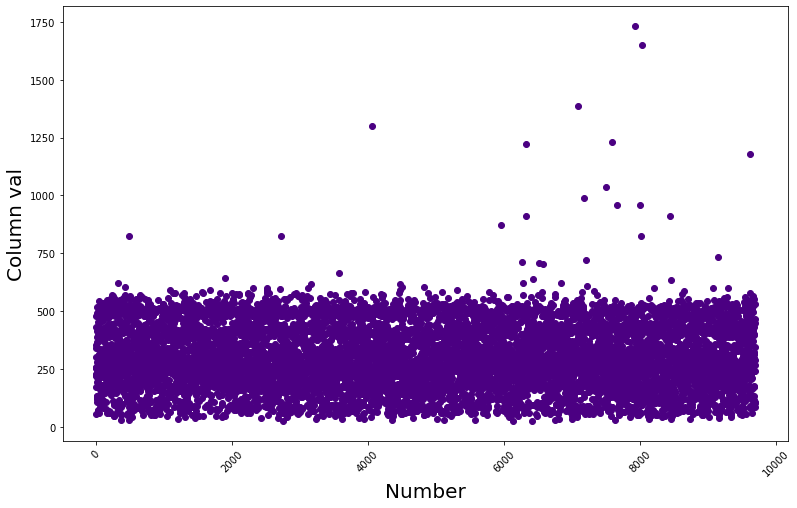

In [5]:
# Display our data
plt.figure(figsize=(13, 8))

plt.scatter(source_df.index, source_df[col_name], c='indigo')
plt.xticks(rotation=45)

plt.xlabel(u'Number', fontsize = 20)
plt.ylabel(u'Column val', fontsize = 20)

In [ ]:
# Creating list of variables for future analysis
ilist= [['attacker_round_end_score', 'defender_round_end_score'], 
        ['attacker_payload_distance', 'defender_payload_distance'], 
        ['winning_team_final_map_score', 'losing_team_final_map_score'],
        ['game_number', 'game_length']]

## Exercise №2
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function (or probability law in case of discrete RV).

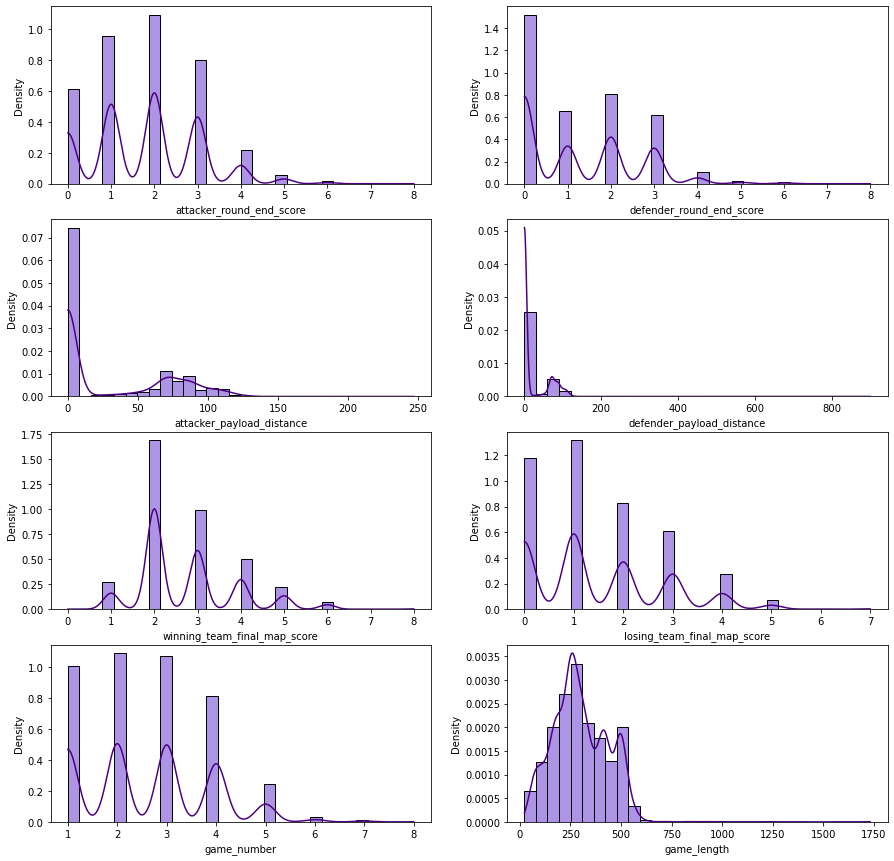

In [33]:
# Plotting a histogram and kernel density estimate
# Draw unnormed histogramm
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
for j in range(0, 2):
    for i in range (0, 4):
        kernel = sp.stats.gaussian_kde(source_df[ilist[i][j]])
        min_amount, max_amount = source_df[ilist[i][j]].min(), source_df[ilist[i][j]].max()
        x = np.linspace(min_amount, max_amount, len(source_df[ilist[i][j]]))
        kde_values = kernel(x)
        sns.histplot(source_df[ilist[i][j]], kde=False, bins=30, stat='density', ax=ax[i, j], palette='Set3', color = 'mediumpurple')
        ax[i, j].plot(x, kde_values, c = 'indigo')

## Exercise №3
You need to make an estimation of order statistics and represent them as “box with whiskers” plot.

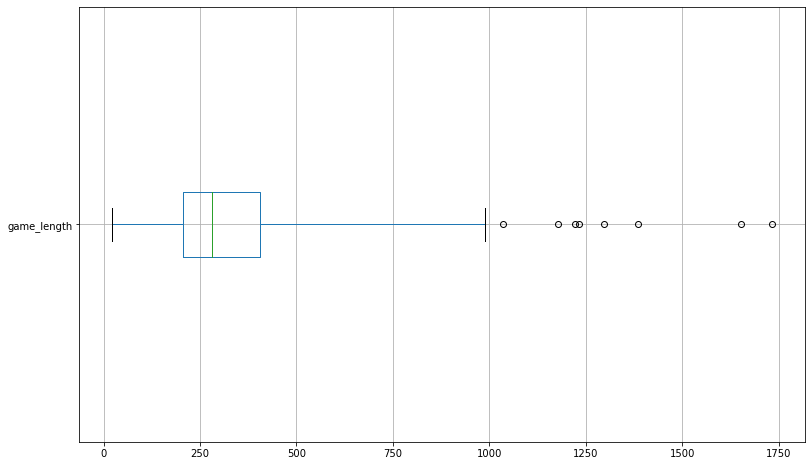

In [34]:
plt.figure(figsize=(13, 8))
# Calculation of sample mean, variance, standard deviation, median
mean = source_df[col_name].mean()
var = source_df[col_name].var()
std = source_df[col_name].std()
median = source_df[col_name].median()
# Box plot
boxplot = source_df.boxplot(column=[col_name], whis=3., vert=False) # defaul whis is 1.5 (to many outliers there)
# boxplot = source_df.boxplot(column=['Accuracy'])

## Exercise №4
Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results. 

In [ ]:
plt.figure(figsize=(13, 8))
# Determination of the parameters of the distribution 

hist_data = plt.hist(source_df[col_name], density=True, bins=50, color='grey')
x = np.linspace(min_amount, max_amount)

if col_name == 'ElapsedTime':
    # The lognorm distribution parameters are determined using the fit function based on the maximum likelihood method
    mle_params = scipy.stats.lognorm.fit(source_df[col_name])
    print("MLE: ", mle_params)
    pdf_mle = scipy.stats.lognorm.pdf(x, *mle_params)

elif col_name == 'Accuracy':
    mle_params = scipy.stats.uniform.fit(source_df[col_name])
    print("MLE: ", mle_params)
    pdf_mle = scipy.stats.uniform.pdf(x, *mle_params)

elif col_name == 'Score':
    mle_params = scipy.stats.lognorm.fit(source_df[col_name], loc=1.1, scale=1.1) # Make initial Guess
    print("MLE: ", mle_params)
    pdf_mle = scipy.stats.lognorm.pdf(x, *mle_params)

plt.plot(x, pdf_mle, color='r')

#  The distribution parameters are determined using the fit function based on least squares method
# Prepare data for least squares
hist_bins = hist_data[1][:-1]  # remove last element
delta = hist_bins[1]-hist_bins[0]
hist_bins += delta / 2 # Take centres of bins
# print(hist_bins)
hist_vals = hist_data[0] # Get the height of bins for least squares
# print(hist_vals)

if col_name == 'ElapsedTime':
    def lognorm(arg_x, s, loc, scale):
        return scipy.stats.lognorm.pdf(arg_x, s, loc, scale)
    
    def lst_sqrs(par_ar, gt, x):
        s, loc, scale = par_ar
        return sum((gt - lognorm(x, s, loc, scale))**2)

    lse_params = minimize(lst_sqrs, [1.1, 1.1, 1.1], method = 'Nelder-Mead', args=(hist_vals, hist_bins), tol=0.001, options={'disp': True})
    print("LSE: ",lse_params.x)
    pdf_lsm = scipy.stats.lognorm.pdf(x, *lse_params.x)

elif col_name == 'Accuracy':

    def uniform(arg_x, loc, scale):
        ret_vals = np.array([1./(scale)] * len(arg_x))

        ret_vals[arg_x < loc] = 0
        ret_vals[arg_x > (loc + scale)] = 0

        return ret_vals

    def lst_sqrs(par_ar, gt, x):
        loc, scale = par_ar
        return sum((gt - uniform(x, loc, scale))**2)

    lse_params = minimize(lst_sqrs, [0., 10.], method = 'Nelder-Mead', args=(hist_vals, hist_bins), tol=0.001)
    print("LSE: ", lse_params.x)
    pdf_lsm = scipy.stats.uniform.pdf(hist_bins, *lse_params.x)

elif col_name == 'Score':
    def lognorm(arg_x, s, loc, scale):
        return scipy.stats.lognorm.pdf(arg_x, s, loc, scale)
    
    def lst_sqrs(par_ar, gt, x):
        s, loc, scale = par_ar
        return sum((gt - lognorm(x, s, loc, scale))**2)

    lse_params = minimize(lst_sqrs, [1.1, 1.1, 1.1], method = 'Nelder-Mead', args=(hist_vals, hist_bins), tol=0.001, options={'disp': True})
    print("LSE: ",lse_params.x)
    pdf_lsm = scipy.stats.lognorm.pdf(x, *lse_params.x)

plt.plot(x, pdf_lsm, color='b')



## Exercise №5
Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method.

In [ ]:
# Print Gained distribs by MLE and LSE



## Exercise №6
Validate your estimated parameters using QQ biplots.

In [ ]:
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs_num = 50
percs = np.linspace(0, 100, percs_num)
qn_real = np.percentile(source_df[col_name], percs)

if col_name == 'ElapsedTime':
    qn_theor = scipy.stats.lognorm.ppf(percs / 100.0, *mle_params)
elif col_name == 'Accuracy':
    qn_theor = scipy.stats.uniform.ppf(percs / 100.0, *mle_params)
elif col_name == 'Score':
    qn_theor = scipy.stats.lognorm.ppf(percs / 100.0, *mle_params)



# Building a quantile biplot
plt.figure(figsize=(13, 8))
plt.plot(qn_real, qn_theor, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(min_amount, max_amount)
plt.ylim(min_amount, max_amount)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')

plt.show()

## Exercise №7
Estimate  correctness of fitted distributions using at least 2 statistical tests.

In [ ]:
# Calculation of the Kolmogorov-Smirnov test, Cramér-von Mises test  and chi-square (Pirson test?)

if col_name == 'ElapsedTime':
    ks = scipy.stats.kstest(source_df[col_name], 'lognorm', mle_params, N=100)
    cvm = scipy.stats.cramervonmises(source_df[col_name], 'lognorm', mle_params)
    # chi2 = scipy.stats.chisquare(source_df[col_name])

elif col_name == 'Accuracy':
    ks = scipy.stats.kstest(source_df[col_name], 'uniform', mle_params, N=100)
    cvm = scipy.stats.cramervonmises(source_df[col_name], 'uniform', mle_params)
    # chi2 = scipy.stats.chisquare(source_df[col_name])

elif col_name == 'Score':
    ks = scipy.stats.kstest(source_df[col_name], 'lognorm', mle_params, N=100)
    cvm = scipy.stats.cramervonmises(source_df[col_name], 'lognorm', mle_params)
    # chi2 = scipy.stats.chisquare(source_df[col_name])

print(ks)
print(cvm)
# print(chi2)